In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

In [3]:
df_pollutants = pd.read_csv('../../data/raw/pollutant_data.csv')

df_measurements = pd.read_csv('../../data/raw/measurement_data.csv')

In [4]:
stats = []
for col in df_measurements.columns:
    stats.append((col, df_measurements[col].nunique(), df_measurements[col].isnull().sum() * 100 / df_measurements.shape[0], df_measurements[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_measurements[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
0,Measurement date,25906,0.0,0.004022,object
1,Station code,25,0.0,4.167712,int64
2,Latitude,25,0.0,4.167712,float64
3,Longitude,25,0.0,4.167712,float64
4,SO2,181,0.0,25.466064,float64
5,NO2,131,0.0,3.012446,float64
6,O3,250,0.0,6.271357,float64
7,CO,162,0.0,22.337947,float64
8,PM10,550,0.0,2.084017,float64
9,PM2.5,321,0.0,3.265024,float64


In [5]:
df_instruments = pd.read_csv('../../data/raw/instrument_data.csv')

In [6]:
df_instruments

,Measurement date,Station code,Item code,Average value,Instrument status
0,2021-01-01 00:00:00,204,0,0.004,0
1,2021-01-01 00:00:00,204,2,0.059,0
2,2021-01-01 00:00:00,204,4,1.200,0
3,2021-01-01 00:00:00,204,5,0.002,0
4,2021-01-01 00:00:00,204,7,73.000,0
...,...,...,...,...,...
3703657,2023-11-30 23:00:00,228,7,41.000,0
3703658,2023-11-30 23:00:00,228,5,0.008,0
3703659,2023-11-30 23:00:00,228,4,0.600,0
3703660,2023-11-30 23:00:00,228,2,0.045,0


In [7]:
stats = []
for col in df_instruments.columns:
    stats.append((col, df_instruments[col].nunique(), df_instruments[col].isnull().sum() * 100 / df_instruments.shape[0], df_instruments[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_instruments[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
0,Measurement date,25906,0.0,0.004050,object
1,Station code,25,0.0,4.196819,int64
2,Item code,6,0.0,16.666667,int64
3,Average value,1010,0.0,4.762530,float64
4,Instrument status,6,0.0,97.381889,int64


In [8]:
# Primero, convertimos la columna 'Timestamp' a datetime, forzando los errores a NaT (Not a Time)
df_measurements['Measurement date'] = pd.to_datetime(df_measurements['Measurement date'], errors='coerce')
df_instruments['Measurement date'] = pd.to_datetime(df_instruments['Measurement date'], errors='coerce')

In [17]:
# Lista de contaminantes presentes en measurement_data
pollutant_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

# Convertir measurement_data de formato ancho a formato largo
df_measure_long = df_measurements.melt(
    id_vars=['Measurement date', 'Station code', 'Latitude', 'Longitude'],
    value_vars=pollutant_columns,
    var_name='Item name',
    value_name='Measurement value'
)

# Unir df_measure_long con df_pollutant para incorporar el 'Item code'
df_measure_long = pd.merge(
    df_measure_long,
    df_pollutants[['Item code', 'Item name']],
    on='Item name',
    how='left'
)

# Realizar el merge final entre measurements e instruments utilizando las columnas de measurement date, station code e item code
df_merged = pd.merge(
    df_measure_long,
    df_instruments[['Measurement date', 'Station code', 'Item code', 'Instrument status']],
    on=['Measurement date', 'Station code', 'Item code'],
    how='left'
)

In [19]:
stats = []
for col in df_merged.columns:
    stats.append((col, df_merged[col].nunique(), df_merged[col].isnull().sum() * 100 / df_merged.shape[0], df_merged[col].value_counts(normalize=True, dropna=False).values[0] * 100, df_merged[col].dtype))
    stats_df = pd.DataFrame(stats, columns=['Columna', 'Valores únicos', '% nulos', '% of values in the biggest category', 'tipo'])
stats_df.sort_values('% nulos', ascending=False)

,Columna,Valores únicos,% nulos,% of values in the biggest category,tipo
7,Instrument status,6,0.693546,96.706500,float64
0,Measurement date,25906,0.000000,0.004022,datetime64[ns]
1,Station code,25,0.000000,4.167712,int64
2,Latitude,25,0.000000,4.167712,float64
3,Longitude,25,0.000000,4.167712,float64
4,Item name,6,0.000000,16.666667,object
5,Measurement value,1014,0.000000,4.763927,float64
6,Item code,6,0.000000,16.666667,int64


In [14]:
def classify_value(pollutant, value):
    """
    Returns: 
       0 -> Good
       1 -> Normal
       2 -> Bad
       3 -> Very Bad
       
    depending on the pollutant and it's measured value
    """
    if pollutant == 'SO2':
        
        if value <= 0.02:
            return 0
        elif value <= 0.05:
            return 1
        elif value <= 0.15:
            return 2
        else:
            return 3
        
    elif pollutant == 'NO2':
        
        if value <= 0.03:
            return 0
        elif value <= 0.06:
            return 1
        elif value <= 0.2:
            return 2
        else:
            return 3
        
    elif pollutant == 'CO':
        
        if value <= 2:
            return 0
        elif value <= 9:
            return 1
        elif value <= 15:
            return 2
        else:
            return 3
        
    elif pollutant == 'O3':
        if value <= 0.03:
            return 0
        elif value <= 0.09:
            return 1
        elif value <= 0.15:
            return 2
        else:
            return 3
        
    elif pollutant == 'PM10':
        if value <= 30:
            return 0
        elif value <= 80:
            return 1
        elif value <= 150:
            return 2
        else:
            return 3
        
    elif pollutant == 'PM2.5':
        if value <= 15:
            return 0
        elif value <= 35:
            return 1
        elif value <= 75:
            return 2
        else:
            return 3
        
    else: 
        return None

df_merged['value_classification'] = df_merged.apply(lambda row: classify_value (row['Item name'], row['Measurement value']), axis = 1)

In [16]:
df_merged['hour'] = df_merged['Measurement date'].dt.hour
df_merged['day'] = df_merged['Measurement date'].dt.day
df_merged['weekday'] = df_merged['Measurement date'].dt.weekday
df_merged['month'] = df_merged['Measurement date'].dt.month
df_merged['quarter'] = df_merged['Measurement date'].dt.quarter
df_merged['year'] = df_merged['Measurement date'].dt.year
df_merged['week_of_year'] = df_merged['Measurement date'].dt.isocalendar().week
df_merged['is_weekend'] = df_merged['weekday'].apply(lambda x: 1 if x >= 5 else 0)

df_merged = df_merged.drop(columns=['Latitude', 'Longitude'])

# Función para asignar temporada según el mes
def assign_season(month):
    if month in [12, 1, 2]:
        return '1'  # Invierno
    elif month in [3, 4, 5]:
        return '2'  # Primavera
    elif month in [6, 7, 8]:
        return '3'  # Verano
    elif month in [9, 10, 11]:
        return '4'  # Otoño

df_merged['season'] = df_merged['month'].apply(assign_season)

In [18]:
new_order = [
    'Measurement date',  
    'hour',
    'day',
    'weekday',
    'is_weekend',
    'week_of_year',
    'month',
    'quarter',
    'season',
    'year',
    'Station code', 
    'Item name', 
    'Item code', 
    'Measurement value', 
    'value_classification',
    'Instrument status'
    
]

df_merged = df_merged[new_order]

df_merged.to_csv('../../data/processed/pollution_process.csv', index = False)

## Gráficos

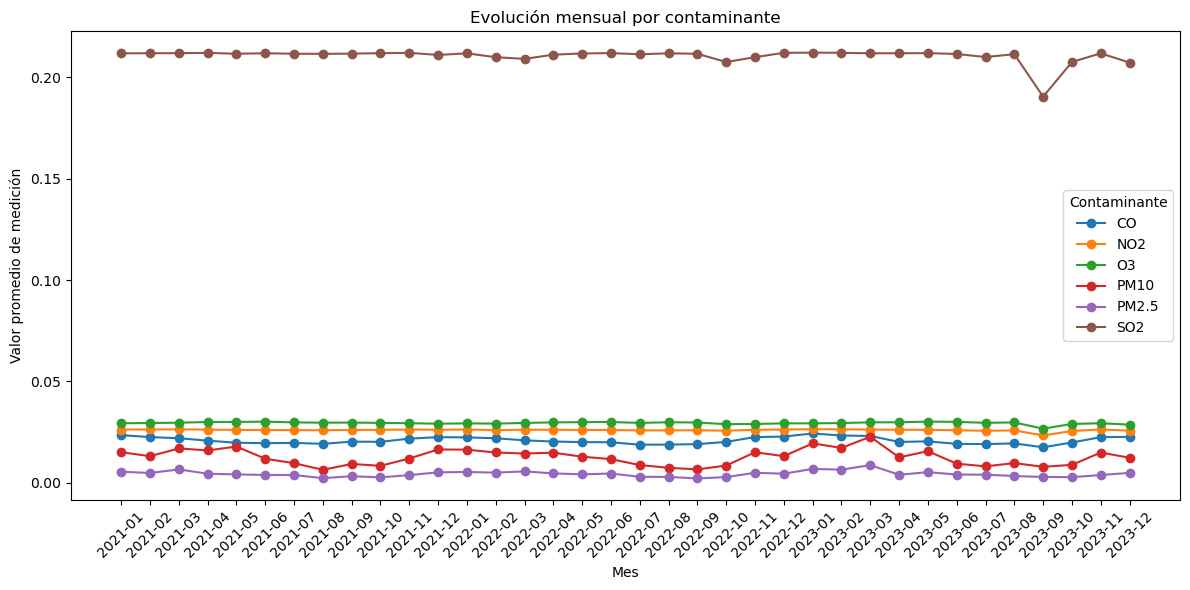

In [63]:
df_merged['year_month'] = df_merged['Measurement date'].dt.to_period('M').astype(str)

# Crear la columna 'normalized_value' usando normalización Min-Max por cada contaminante
df_merged['normalized_value'] = df_merged.groupby('Item name')['Measurement value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Agrupar por año-mes e ítem y calcular el promedio de 'Measurement value'
monthly_norm = df_merged.groupby(['year_month', 'Item name'])['normalized_value'].mean().reset_index()

plt.figure(figsize=(12,6))
for pollutant in monthly_norm['Item name'].unique():
    subset = monthly_norm[monthly_norm['Item name'] == pollutant]
    plt.plot(subset['year_month'], subset['normalized_value'], marker='o', label=pollutant)

plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Valor promedio de medición")
plt.title("Evolución mensual por contaminante")
plt.legend(title="Contaminante")
plt.tight_layout()
plt.show()

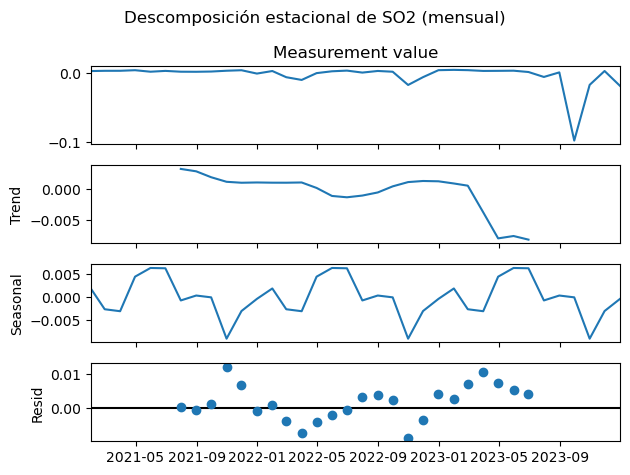

In [45]:
# Seleccionar datos de SO2 y re-muestrear a mensual
df_so2 = df_merged[df_merged['Item name'] == 'SO2'].copy()
df_so2 = df_so2.set_index('Measurement date')
df_so2_monthly = df_so2['Measurement value'].resample('M').mean()

# Descomponer la serie (modelo aditivo)
decomposition = seasonal_decompose(df_so2_monthly, model='additive')
decomposition.plot()
plt.suptitle("Descomposición estacional de SO2 (mensual)")
plt.tight_layout()
plt.show()

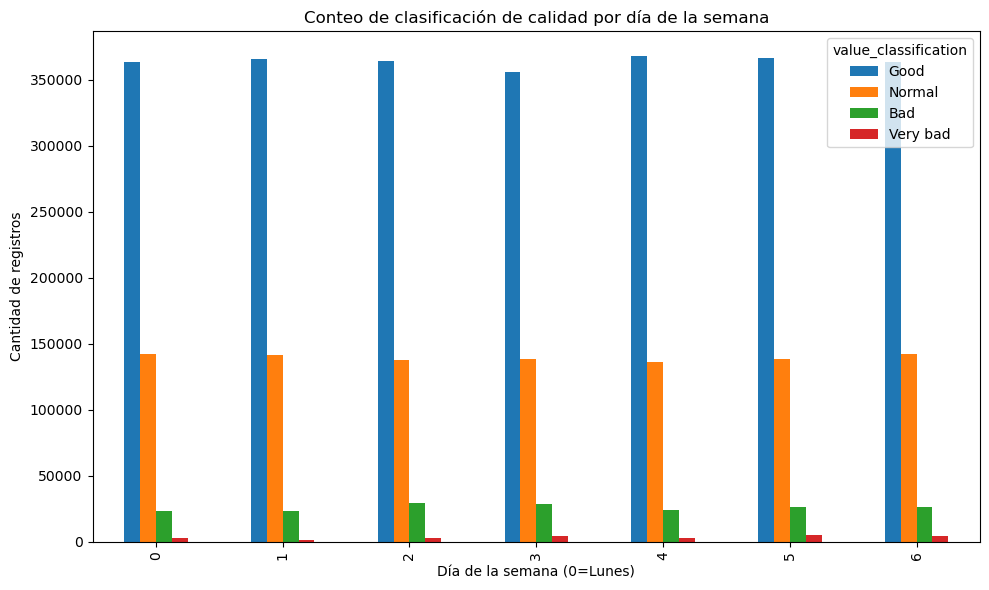

In [50]:
# Contar registros de quality_label agrupados por 'weekday'
quality_weekday = df_merged.groupby("weekday")["value_classification"].value_counts().unstack(fill_value=0)

quality_weekday.plot(kind="bar", figsize=(10,6))
plt.xlabel("Día de la semana (0=Lunes)")
plt.ylabel("Cantidad de registros")
plt.title("Conteo de clasificación de calidad por día de la semana")
plt.legend(title="value_classification", labels=["Good", "Normal", "Bad", "Very bad"])
plt.tight_layout()
plt.show()

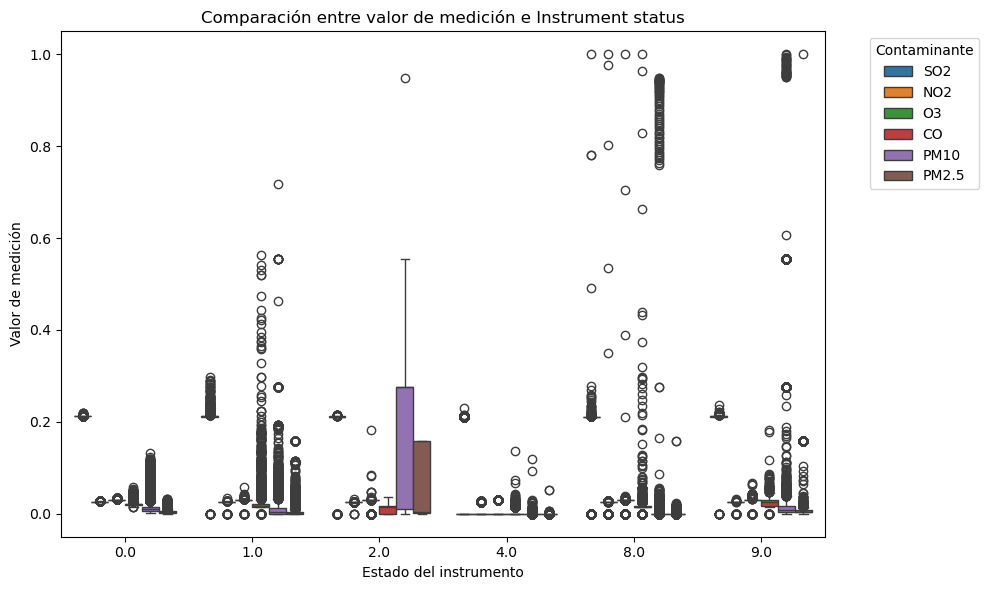

In [69]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_merged, x="Instrument status", y="normalized_value", hue="Item name")
plt.xlabel("Estado del instrumento")
plt.ylabel("Valor de medición")
plt.title("Comparación entre valor de medición e Instrument status")
plt.legend(title="Contaminante", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()